<a href="https://colab.research.google.com/github/drdww/OPIM5641/blob/main/Module5/M5_2/0_Network_Transshipment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Problems: Transshipment
**OPIM 5641: Business Decision Modeling - University of Connecticut**

We are going to use a balance equation to handle flow through the network! Our objective function is going to be a two-part equation that needs to handle flow to the DC and flow from the DC.

Please refer to Powell Chapter 10 for more examples.

----------------------------------------------------------

We previously saw that the assignment problem is a simplified version of the transportation problem, with unit supplies and demands. 

By contrast, the transshipment problem is a more complex version of the transportation problem, characterized by two stages of flow instead of just one. 

In the Bonner Electronics diagram, there are two levels in the system (plants and warehouses), and all of the flow takes place in one stage, from plants to warehouses. 

In more complex logistics systems, there are three major levels: plants, distribution centers (DCs), and warehouses, and in such systems, the flow often takes place in two stages.

In [ ]:
pip install pyomo

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

import pyomo.environ as pyomo

In [ ]:
from __future__ import division
from pyomo.environ import *

# Example

**[Example 10.4 from Powell]** The Western Paper Company manufactures paper at three factories (F1, F2, F3) on the West Coast.
Their products are shipped by rail to a pair of depots (D1 and D2), one in the Midwest and one in the
South. At the depots, the products are repackaged and sent by truck to three regional warehouses
(W1, W2, and W3) around the country, in response to replenishment orders.
Each of the factories has a known monthly production capacity, and the three regional
warehouses have placed their demands for next month. The following tables summarize the data that
have been collected for this planning problem:

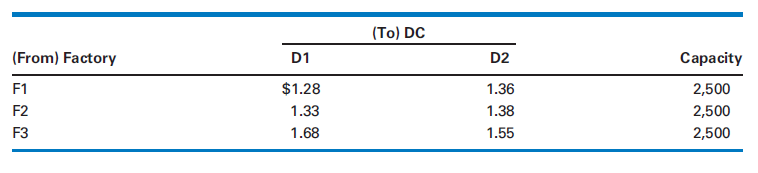

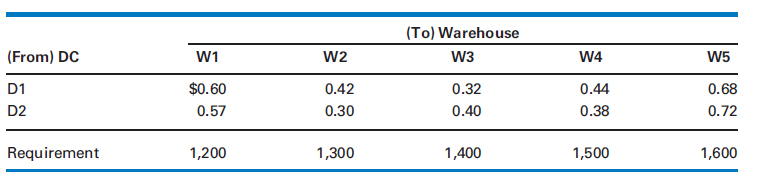

In [ ]:
# more supply than demand - good! this makes it easy to solve.
Supply = 2500*3
print('Supply:', Supply)
Demand = 1200 + 1300 + 1400 + 1500 + 1600
print('Demand:', Demand)

Supply: 7500
Demand: 7000


Knowing the costs of transporting goods from factories to DCs and from DCs to warehouses,
Western Paper is interested in scheduling its material flow at the minimum possible cost.

# Formulation

The left-hand side of the diagram shows the potential flows from factories to DCs, and the
right-hand side shows the potential flows from DCs to warehouses. The DCs are called
**transshipment points** because material arrives at those locations and is then subject to
further shipment. At the heart of the transshipment structure is the need to coordinate the
two transportation stages at the transshipment points. This coordination is governed by
the **conservation law** of flows in networks: The total quantity flowing out of a node must
equal the total quantity flowing in.

We use x to represent a first-stage flow, from
factory to DC and y to represent a second-stage flow from DC to warehouse. Thus, let
$x_{21}$ represent the quantity shipped from F2 to D1, and let $y_{23}$ represent the quantity
shipped from D2 to W3. With this notation, we can write the conservation relationship

**For D1, we have**:

(Flow Out) =  (Flow In)

or 

(Flow Out) - (Flow In) = 0

or

$(y_{11} + y_{12} + y_{13} + y_{14}+ y_{15}) - (x_{11} + x_{21} +  x_{31}) = 0 $

*(left) flow out of the the **first** DC and (right) flow into the **first** DC must balance*


**For D2, we have** :

$(y_{21} + y_{22} + y_{23} + y_{24} + y_{25}) - (x_{12} + x_{22} + x_{32}) = 0 $

*(left) flow out of the the **second** DC and (right) flow into the **second** DC must balance*





Here is the network diagram for Western Paper : 


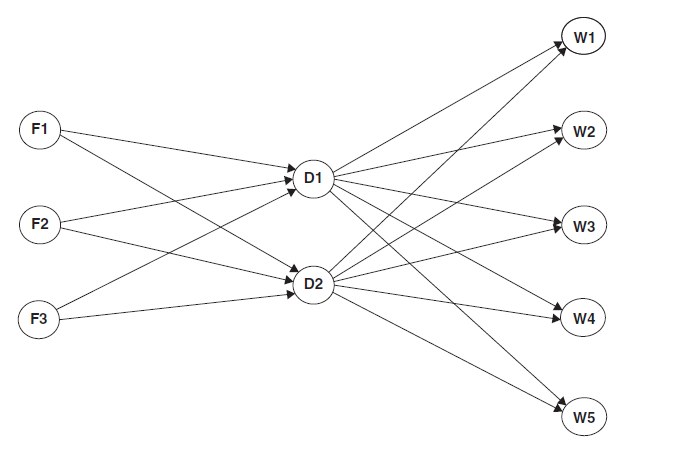

We can see that the conservation law takes the form of an equality constraint for
particular nodes in the network. This equality constraint is sometimes called a **balance** **equation** because it ensures perfect balance between inputs and outputs.
We can now develop an algebraic statement of the transshipment model, by
combining the types of supply and demand constraints we saw in the transportation
model with the balance equations introduced here for transshipment nodes. Our model
takes the following form:

**Objective Function**
$ \min(z) = 1.28*x_{11} + 1.36*x_{12} + 1.33*x_{21} + 1.38*x_{22} + 1.68*x_{31} + 1.55*x_{32} + 0.60*y_{11} + 0.42*y_{12} +0.32*y_{13} + 0.44*y_{14} + 0.68*y_{15} +0.57*y_{21} + 0.3*y_{22} + 0.4*y_{23} + 0.38*y_{24} + 0.72*y_{25}$


Subject to...
## Supply Constraints

*Note: $x_{11}$ means flow from $F1$ to $D1$; $x_{12}$ means flow from $F1$ to $D2$*

* $x_{11} + x_{12} <= 2500$
* $x_{21} + x_{22} <= 2500$
* $x_{31} + x_{32} <= 2500$

## Demand Constraints
*Note: $y_{11}$ means the flow from $D1$ to $W1$, and $y_{21}$ means flow from $D2$ to $W1$. We are satisfying the demand at the $W$ warehouses.*

* $y_{11} + y_{21} >= 1200$
* $y_{12} + y_{22} >= 1300$
* $y_{13} + y_{23} >= 1400$
* $y_{14} + y_{24} >= 1500$
* $y_{15} + y_{25} >= 1600$

## Balance/Flow Constraints
* $-x_{11} - x_{21} - x_{31} + y_{11} + y_{12} + y_{13} + y_{14} + y_{15} == 0$
* $-x_{12} - x_{22} - x_{32} + y_{21} + y_{22} + y_{23} + y_{24} + y_{25} == 0$

Remember, $x_{11}$ is the flow from the first factory to the first DC and $y_{11}$ is the flow from the first DC to the first of five stores.

# Model

In [ ]:
# declare the model
model = ConcreteModel()

# decision variables (you lose some granularity in the constraints with this naming convention, but it is convenient!)
model.x = Var([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], domain=NonNegativeReals)

# first stage of network model
x11 = model.x[1] # f1 to d1
x12 = model.x[2] # f1 to d2
x21 = model.x[3] # f2 to d1
x22 = model.x[4] # ...
x31 = model.x[5]
x32 = model.x[6]

# second stage of network model
y11 = model.x[7] # d1 to w1
y21 = model.x[8] # d2 to w1
y12 = model.x[9] # d1 to w2
y22 = model.x[10] # d2 to w2
y13 = model.x[11] # ...
y23 = model.x[12]
y14 = model.x[13]
y24 = model.x[14]
y15 = model.x[15]
y25 = model.x[16]

# objective
model.OBJ = Objective(expr = 1.28*x11 + 1.36*x12 + 1.33*x21 + 1.38*x22 + 1.68*x31 + 1.55*x32 + # stage 1 costs
                            0.60*y11 + 0.42*y12 + 0.32*y13 + 0.44*y14 + 0.68*y15 + 0.57*y21 + 0.3*y22 + # stage 2 costs
                            0.4*y23 + 0.38*y24 + 0.72*y25,
                      sense=minimize) # remember, we are minimizing costs!

# constraints

# supply - can't ship more than we make!
model.Constraint1 = Constraint(expr = x11 + x12 <= 2500) # flow from f1 can't be more than capacity... supply constraint
model.Constraint2 = Constraint(expr = x21 + x22 <= 2500) # flow from f2 can't be more than capacity
model.Constraint3 = Constraint(expr = x31 + x32 <= 2500) # ...

# demand constraints - we must satisfy demand!
model.Constraint4 = Constraint(expr = y11 + y21 >= 1200) # flow into store 1 can't be more than demand ... demand constraint
model.Constraint5 = Constraint(expr = y12 + y22 >= 1300)
model.Constraint6 = Constraint(expr = y13 + y23 >= 1400)
model.Constraint7 = Constraint(expr = y14 + y24 >= 1500)
model.Constraint8 = Constraint(expr = y15 + y25 >= 1600)

# balance constraints - you need to assume net flow into each DC is 0
model.Constraint9 = Constraint(expr = -x11 - x21 - x31 + y11 + y12 + y13 + y14 + y15 == 0) # balance for first DC
model.Constraint10 = Constraint(expr = -x12 - x22 - x32 + y21 + y22 + y23 + y24 + y25 == 0) # balance for second DC

The formulation contains three less-than constraints (one per factory), five greater-than constraints (one per warehouse), and two equality constraints (one per DC). The
optimal solution is with a total cost of $12,881. Thus, Western Paper can recognize both stages of its supply chain when it optimizes its distribution costs in one comprehensive model.

The optimal flows, at node D1, we can see that the total inflow is 4,200, and the total outflow is 4,200. At node D2, the total inflow is 2,800, matching the total outflow of 2,800.  
The diagram to produce a quick visual check that the decision
variables in the optimal solution are consistent with the balance equations for the transshipment points.

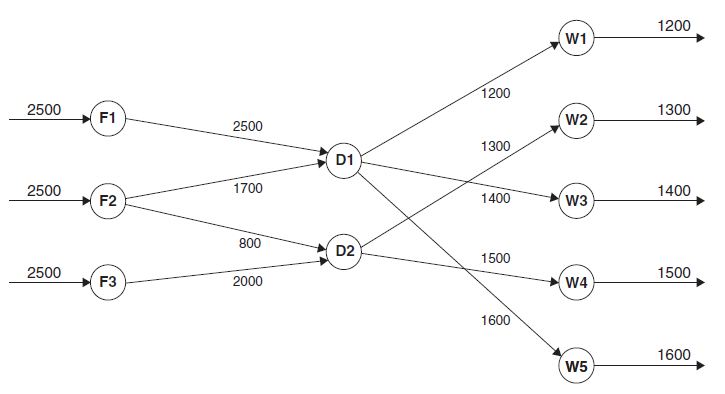

The network diagram serves as a convenient visual check and as a visual
aid for communicating the results of the analysis.

In [ ]:
model.pprint()

1 Set Declarations
    x_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   16 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}

1 Var Declarations
    x : Size=16, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :  None :  None : False :  True : NonNegativeReals
          2 :     0 :  None :  None : False :  True : NonNegativeReals
          3 :     0 :  None :  None : False :  True : NonNegativeReals
          4 :     0 :  None :  None : False :  True : NonNegativeReals
          5 :     0 :  None :  None : False :  True : NonNegativeReals
          6 :     0 :  None :  None : False :  True : NonNegativeReals
          7 :     0 :  None :  None : False :  True : NonNegativeReals
          8 :     0 :  None :  None : False :  True : NonNegativeReals
          9 :     0 :  None :  None : False :  True : NonNegativeReals
         10 :     0 :  None :  None 

In [ ]:
SolverFactory('cbc').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 12881.0
  Upper bound: 12881.0
  Number of objectives: 1
  Number of constraints: 11
  Number of variables: 17
  Number of nonzeros: 16
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of crea

In [ ]:
print("Total_cost = ", value(model.OBJ())) 

print('\n', 'STAGE 1: F to D')
# flow from F to D1
print('Flow from F1 to D1:', model.x[1]())
print('Flow from F2 to D1:', model.x[3]())
print('Flow from F3 to D1:', model.x[5]())

# flow from F to D2
print('Flow from F1 to D2:', model.x[2]())
print('Flow from F2 to D2:', model.x[4]())
print('Flow from F3 to D2:', model.x[6]())

print('\n', 'STAGE 2: D to W')
print('Flow from D1 to W1:', model.x[7]())
print('Flow from D1 to W2:', model.x[9]())
print('Flow from D1 to W3:', model.x[11]())
print('Flow from D1 to W4:', model.x[13]())
print('Flow from D1 to W5:', model.x[15]())
print('Flow from D2 to W1:', model.x[8]())
print('Flow from D2 to W2:', model.x[10]())
print('Flow from D2 to W3:', model.x[12]())
print('Flow from D2 to W4:', model.x[14]())
print('Flow from D2 to W5:', model.x[16]())

Total_cost =  12881.0

 STAGE 1: F to D
Flow from F1 to D1: 2500.0
Flow from F2 to D1: 1700.0
Flow from F3 to D1: 0.0
Flow from F1 to D2: 0.0
Flow from F2 to D2: 800.0
Flow from F3 to D2: 2000.0

 STAGE 2: D to W
Flow from D1 to W1: 1200.0
Flow from D1 to W2: 0.0
Flow from D1 to W3: 1400.0
Flow from D1 to W4: 0.0
Flow from D1 to W5: 1600.0
Flow from D2 to W1: 0.0
Flow from D2 to W2: 1300.0
Flow from D2 to W3: 0.0
Flow from D2 to W4: 1500.0
Flow from D2 to W5: 0.0


Analyze the output!!! Look at which nodes support other nodes in the network. The total cost you see is a function of your Stage 1 and Stage 2 costs (you are summing them together).

**On your own:** Students can check to see which constraints are binding and look at how routes will change as a function of changing supply or demand!